In [5]:
import numpy as np
import pandas as pd
import sys
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris

In [64]:
X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame=True, return_X_y=True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "iris": X_raw_iris,
    "parkinsons": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",
        sep=",",
    ),
    "ionosphere": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
        sep=",",
        header=None,
    ),
    "credit": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data",
        header=None,
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "spam": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "letter": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
        header=None,
    ),
}

/var/folders/nz/tg5hpfc573nbbh7r4ftd2hwr0000gn/T/ipykernel_29338/612246032.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  "airfoil": pd.read_csv(


In [2]:
for df in raw_datasets:
    print(df, len(raw_datasets[df]))

iris 150
parkinsons 195
ionosphere 351
credit 690
blood 748
airfoil 1503
wine_red 1599
spam 4600
wine_white 4898
letter 20000


In [3]:
from benchmark_imputation import simulate_scenarios
from hyperimpute.plugins.imputers import Imputers
import warnings
import pandas as pd

import hyperimpute.logger as log

log.add(sink=sys.stderr, level="INFO")

imputers = Imputers()

warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


## Model insights

In [4]:
from hyperimpute.plugins.utils.metrics import RMSE
from benchmark_imputation import ws_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from time import time
from hyperimpute.utils.distributions import enable_reproducible_results
from joblib import Parallel, delayed

dispatcher = Parallel(n_jobs=2)


def get_imputer():
    return imputers.get(
        "hyperimpute",
        optimizer="hyperband",
        select_lazy=False,
    )


def evaluate_model_trace_for_dataset(
    name: str,
    X_raw: pd.DataFrame,
    scenarios: list = ["MAR"],
    miss_pct: list = [0.1, 0.3, 0.5, 0.7],
    debug: bool = True,
):
    imputation_scenarios = simulate_scenarios(
        X_raw, column_limit=10, sample_columns=False
    )
    traces = {}

    def _local_eval(scenario, missingness):
        warnings.filterwarnings("ignore")

        x, x_miss, mask = imputation_scenarios[scenario][missingness]
        print("  evaluate ", name, scenario, missingness)
        try:
            model = get_imputer()
            model.fit_transform(x_miss.copy())

            return model.trace()["models"]

        except BaseException as e:
            print("scenario failed", str(e))

    for scenario in scenarios:
        traces[scenario] = {}

        local_traces = dispatcher(
            delayed(_local_eval)(scenario, miss) for miss in miss_pct
        )

        for local_trace, miss in zip(local_traces, miss_pct):
            x, x_miss, mask = imputation_scenarios[scenario][miss]
            observed_x = x_miss[~x_miss.isnull().any(axis=1)]
            traces[scenario][miss] = {
                "model_trace": local_trace,
                "observed_rows": len(observed_x),
            }

    return traces


def evaluate_dataset(dataset, seed: int = 0):
    enable_reproducible_results(seed)

    start = time()
    df = raw_datasets[dataset]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = LabelEncoder().fit_transform(df[col])

    model_trace = evaluate_model_trace_for_dataset(dataset, df)

    print(f"      evaluation for {dataset} took {time() - start}")
    return model_trace

In [5]:
import json


full_output = {}
for dataset in raw_datasets:
    print("eval dataset", dataset)
    try:
        full_output[dataset] = evaluate_dataset(dataset)
    except BaseException as e:
        print("scenario failed", dataset, e)
        continue

eval dataset iris
      evaluation for iris took 57.780794858932495
eval dataset parkinsons
      evaluation for parkinsons took 296.8676950931549
eval dataset ionosphere
      evaluation for ionosphere took 411.256963968277
eval dataset credit
      evaluation for credit took 371.2457778453827
eval dataset blood
      evaluation for blood took 163.5030562877655
eval dataset airfoil
      evaluation for airfoil took 242.5688955783844
eval dataset wine_red
      evaluation for wine_red took 799.1282353401184
eval dataset spam
      evaluation for spam took 793.1668064594269
eval dataset wine_white
      evaluation for wine_white took 1938.870751619339
eval dataset letter
      evaluation for letter took 1513.2517094612122


In [11]:
with open("general_results/model_selection_trace.json", "w") as f:
    json.dump(full_output, f)

# Plots

## By miss ratio

In [6]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

with open("model_selection_trace.json") as f:
    data = json.load(f)

output_dir = Path("diagrams/model_selection")

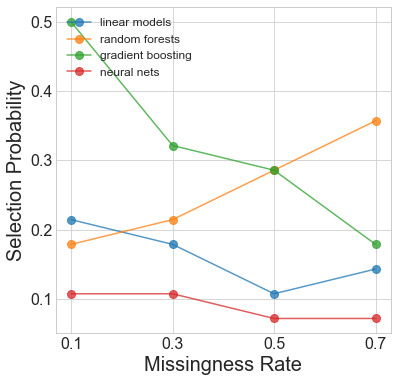

In [61]:
def normalize_model_name(name):
    return {
        "linear_regression": "linear models",
        "logistic_regression": "linear models",
        "xgboost": "gradient boosting",
        "xgboost_regressor": "gradient boosting",
        "catboost": "gradient boosting",
        "catboost_regressor": "gradient boosting",
        "random_forest_regressor": "random forests",
        "random_forest": "random forests",
        "neural_nets_regression": "neural nets",
        "neural_nets": "neural nets",
    }[name]


def compress_model_trace(trace):
    all_models = []

    for col in trace:
        all_models.extend(np.unique(trace[col]).tolist())

    raw_models = np.unique(all_models).tolist()
    models = []
    for mod in raw_models:
        models.append(normalize_model_name(mod))

    return models


def generate_normalized_model_count(data, scenario="MAR"):
    model_tracking = {}
    for data_set in data:
        for missingness in ["0.1", "0.3", "0.5", "0.7"]:
            trace = data[data_set][scenario][missingness]
            models_selected = compress_model_trace(trace["model_trace"])

            for model in models_selected:
                if not model_tracking.get(missingness, {}).get(model, {}):
                    if not model_tracking.get(missingness, {}):
                        model_tracking[missingness] = {model: 1}
                    else:
                        model_tracking[missingness][model] = 1
                else:
                    model_tracking[missingness][model] += 1

    unique_models = []
    for missingness in model_tracking:
        models = list(model_tracking[missingness].keys())
        for model in models:
            if model not in unique_models:
                unique_models.append(model)

    normalized_model_count = {}
    total_model_count = sum([count for model, count in model_tracking["0.1"].items()])
    for model in unique_models:
        normalized_model_count[model] = [0, 0, 0, 0]
        for index, missingness in enumerate(model_tracking):
            try:
                normalized_model_count[model][index] = (
                    model_tracking[missingness][model] / total_model_count
                )
            except KeyError:
                pass

    return normalized_model_count


def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    missingness_rates = [0.1, 0.3, 0.5, 0.7]
    for model in normalized_model_count:
        plt.plot(
            missingness_rates,
            normalized_model_count[model],
            label=model,
            marker="o",
            ms=8,
            alpha=0.75,
        )

    plt.xlabel("Missingness Rate", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.xticks([0.1, 0.3, 0.5, 0.7], fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(prop={"size": 12}, loc=2)

    plt.savefig(output_dir / f"model_selection_by_miss_cnt.png")

    plt.show()


normalized_model_count = generate_normalized_model_count(data, "MAR")
plot_figure(normalized_model_count)

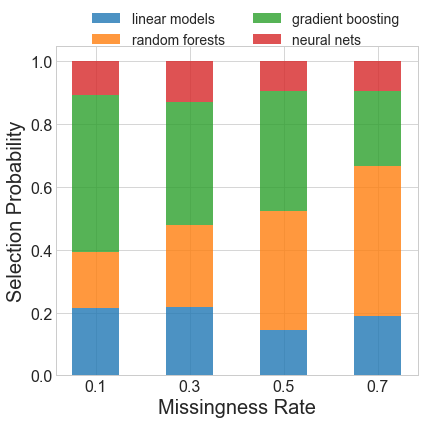

In [96]:
def normalize_model_name(name):
    return {
        "linear_regression": "linear models",
        "logistic_regression": "linear models",
        "xgboost": "gradient boosting",
        "xgboost_regressor": "gradient boosting",
        "catboost": "gradient boosting",
        "catboost_regressor": "gradient boosting",
        "random_forest_regressor": "random forests",
        "random_forest": "random forests",
        "neural_nets_regression": "neural nets",
        "neural_nets": "neural nets",
    }[name]


def compress_model_trace(trace):
    all_models = []

    for col in trace:
        all_models.extend(np.unique(trace[col]).tolist())

    raw_models = np.unique(all_models).tolist()
    models = []
    for mod in raw_models:
        models.append(normalize_model_name(mod))

    return models


def generate_normalized_model_count(data, scenario="MAR"):
    model_tracking = {}
    for data_set in data:
        for missingness in ["0.1", "0.3", "0.5", "0.7"]:
            trace = data[data_set][scenario][missingness]
            models_selected = compress_model_trace(trace["model_trace"])

            for model in models_selected:
                if not model_tracking.get(missingness, {}).get(model, {}):
                    if not model_tracking.get(missingness, {}):
                        model_tracking[missingness] = {model: 1}
                    else:
                        model_tracking[missingness][model] = 1
                else:
                    model_tracking[missingness][model] += 1

    unique_models = []
    for missingness in model_tracking:
        models = list(model_tracking[missingness].keys())
        for model in models:
            if model not in unique_models:
                unique_models.append(model)

    normalized_model_count = {}
    for model in unique_models:
        normalized_model_count[model] = [0, 0, 0, 0]
        for index, missingness in enumerate(model_tracking):
            total_model_count = sum([count for model, count in model_tracking[missingness].items()])
            try:
                normalized_model_count[model][index] = (
                    model_tracking[missingness][model] / total_model_count
                )
            except KeyError:
                pass

    return normalized_model_count

def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    missingness_rates = [0.1, 0.3, 0.5, 0.7]
    bottom = np.zeros(4)
    for index, model in enumerate(normalized_model_count):
        plt.bar(
            missingness_rates,
            normalized_model_count[model],
            width=0.1,
            label=model,
            alpha=0.8,
            bottom=bottom
        )
        bottom += np.array(normalized_model_count[model])
    plt.xlabel("Missingness Rate", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.xticks([0.1, 0.3, 0.5, 0.7], fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(prop={"size": 14}, ncol=2, shadow='True', loc='center', bbox_to_anchor=(0, 1.05, 1.05, 0))
    plt.tight_layout()

    plt.savefig(output_dir / f"model_selection_by_miss_cnt.png")

    plt.show()

normalized_model_count = generate_normalized_model_count(data, "MAR")
plot_figure(normalized_model_count)

## By observed data size

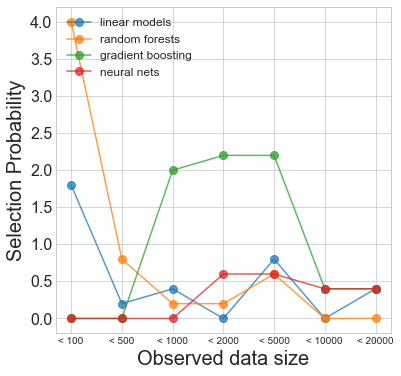

In [65]:
buckets = [100, 500, 1000, 2000, 5000, 10000, 20000]


def get_size_bucket(df_size):
    for thresh in buckets:
        if df_size - 1 < thresh:
            return f"< {thresh}"
    raise RuntimeError(f"unsupported {df_size}")


def generate_model_to_availability_count(data, scenario="MAR"):
    model_tracking = {}
    for data_set in data:
        raw_df = raw_datasets[data_set]
        df_len = len(raw_df)
        for miss_pct in [0.1, 0.3, 0.5, 0.7]:
            missingness = str(miss_pct)
            trace = data[data_set][scenario][missingness]
            observed_data = int((1 - miss_pct) * df_len)
            models_selected = compress_model_trace(trace["model_trace"])

            bucket = get_size_bucket(observed_data)

            for model in models_selected:
                if not model_tracking.get(bucket, {}).get(model, {}):
                    if not model_tracking.get(bucket, {}):
                        model_tracking[bucket] = {model: 1}
                    else:
                        model_tracking[bucket][model] = 1
                else:
                    model_tracking[bucket][model] += 1

    unique_models = []
    for bucket in model_tracking:
        models = list(model_tracking[bucket].keys())
        for model in models:
            if model not in unique_models:
                unique_models.append(model)

    normalized_model_count = {}
    total_model_count = sum([count for model, count in model_tracking["< 100"].items()])
    for model in unique_models:
        normalized_model_count[model] = [0] * len(buckets)
        for index, bucket in enumerate(model_tracking):
            try:
                normalized_model_count[model][index] = (
                    model_tracking[bucket][model] / total_model_count
                )
            except KeyError:
                pass

    return normalized_model_count


def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    for model in normalized_model_count:
        plt.plot(
            [get_size_bucket(bucket) for bucket in buckets],
            normalized_model_count[model],
            label=model,
            marker="o",
            ms=8,
            alpha=0.75,
        )

    plt.xlabel("Observed data size", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.yticks(fontsize=16)
    plt.legend(prop={"size": 12}, loc=2)

    plt.savefig(output_dir / f"model_selection_by_data_availability.png")

    plt.show()


out = generate_model_to_availability_count(data, "MAR")
plot_figure(out)

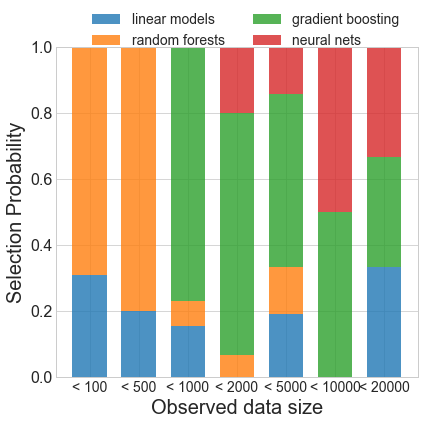

In [98]:
buckets = [100, 500, 1000, 2000, 5000, 10000, 20000]


def get_size_bucket(df_size):
    for thresh in buckets:
        if df_size - 1 < thresh:
            return f"< {thresh}"
    raise RuntimeError(f"unsupported {df_size}")


def generate_model_to_availability_count(data, scenario="MAR"):
    model_tracking = {}
    for data_set in data:
        raw_df = raw_datasets[data_set]
        df_len = len(raw_df)
        for miss_pct in [0.1, 0.3, 0.5, 0.7]:
            missingness = str(miss_pct)
            trace = data[data_set][scenario][missingness]
            observed_data = int((1 - miss_pct) * df_len)
            models_selected = compress_model_trace(trace["model_trace"])

            bucket = get_size_bucket(observed_data)

            for model in models_selected:
                if not model_tracking.get(bucket, {}).get(model, {}):
                    if not model_tracking.get(bucket, {}):
                        model_tracking[bucket] = {model: 1}
                    else:
                        model_tracking[bucket][model] = 1
                else:
                    model_tracking[bucket][model] += 1

    unique_models = []
    for bucket in model_tracking:
        models = list(model_tracking[bucket].keys())
        for model in models:
            if model not in unique_models:
                unique_models.append(model)

    normalized_model_count = {}
    for model in unique_models:
        normalized_model_count[model] = [0] * len(buckets)
        for index, bucket in enumerate(model_tracking):
            total_model_count = sum([count for model, count in model_tracking[bucket].items()])
            try:
                normalized_model_count[model][index] = (
                    model_tracking[bucket][model] / total_model_count
                )
            except KeyError:
                pass

    return normalized_model_count


def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    bottom = np.zeros(len(buckets))
    for model in normalized_model_count:
        plt.bar(
            [get_size_bucket(bucket) for bucket in buckets],
            normalized_model_count[model],
            width=0.7,
            label=model,
            alpha=0.8,
            bottom=bottom
        )
        bottom += np.array(normalized_model_count[model])

    plt.xlabel("Observed data size", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)
    plt.legend(prop={"size": 14}, ncol=2, shadow='True', loc='center', bbox_to_anchor=(0, 1.05, 1.05, 0))
    plt.tight_layout()

    plt.savefig(output_dir / f"model_selection_by_data_availability.png")

    plt.show()


out = generate_model_to_availability_count(data, "MAR")
plot_figure(out)

## Plot by iterations

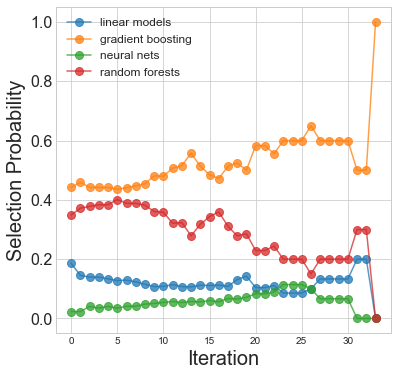

In [73]:
def generate_model_by_iteration(data, scenario="MAR"):
    iteration_tracking = {
        "linear models": [0] * 100,
        "gradient boosting": [0] * 100,
        "neural nets": [0] * 100,
        "random forests": [0] * 100,
    }

    for data_set in data:
        for miss_pct in data[data_set][scenario]:
            missingness = str(miss_pct)
            trace = data[data_set][scenario][missingness]
            models_selected = trace["model_trace"]
            for col in models_selected:
                for it, model in enumerate(models_selected[col]):
                    iteration_tracking[normalize_model_name(model)][it] += 1

    max_iter = 0
    for it in range(100):
        total_models = 0
        for model_class in iteration_tracking:
            total_models += iteration_tracking[model_class][it]
        if total_models == 0:
            max_iter = it
            break

        for model_class in iteration_tracking:
            iteration_tracking[model_class][it] /= total_models

    for model_class in iteration_tracking:
        iteration_tracking[model_class] = iteration_tracking[model_class][:max_iter]

    return iteration_tracking


def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    for model in normalized_model_count:
        plt.plot(
            range(len(normalized_model_count[model])),
            normalized_model_count[model],
            label=model,
            marker="o",
            ms=8,
            alpha=0.75,
        )

    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.yticks(fontsize=16)
    plt.legend(prop={"size": 12}, loc=2)

    plt.savefig(output_dir / f"model_selection_by_iteration.png")

    plt.show()


out = generate_model_by_iteration(data, "MAR")
plot_figure(out)

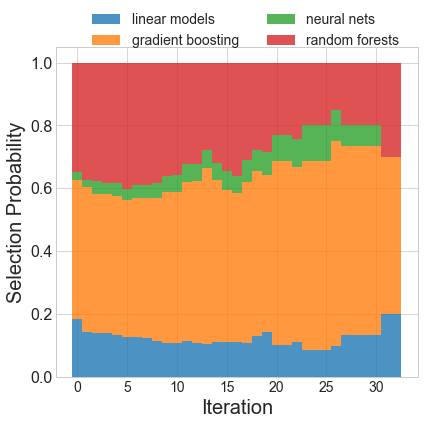

In [99]:
def generate_model_by_iteration(data, scenario="MAR"):
    iteration_tracking = {
        "linear models": [0] * 100,
        "gradient boosting": [0] * 100,
        "neural nets": [0] * 100,
        "random forests": [0] * 100,
    }

    for data_set in data:
        for miss_pct in data[data_set][scenario]:
            missingness = str(miss_pct)
            trace = data[data_set][scenario][missingness]
            models_selected = trace["model_trace"]
            for col in models_selected:
                for it, model in enumerate(models_selected[col]):
                    iteration_tracking[normalize_model_name(model)][it] += 1

    max_iter = 0
    for it in range(100):
        total_models = 0
        for model_class in iteration_tracking:
            total_models += iteration_tracking[model_class][it]
        if total_models == 0:
            max_iter = it
            break

        for model_class in iteration_tracking:
            iteration_tracking[model_class][it] /= total_models

    for model_class in iteration_tracking:
        iteration_tracking[model_class] = iteration_tracking[model_class][:max_iter]

    return iteration_tracking


def plot_figure(normalized_model_count):
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(6, 6))
    bottom = np.zeros(len(normalized_model_count['linear models'])-1)
    for model in normalized_model_count:
        plt.bar(
            range(len(normalized_model_count[model])-1),
            normalized_model_count[model][:-1],
            width=1,
            label=model,
            alpha=0.8,
            bottom=bottom
        )
        bottom += np.array(normalized_model_count[model][:-1])
        
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Selection Probability", fontsize=20)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)
    plt.legend(prop={"size": 14}, ncol=2, shadow='True', loc='center', bbox_to_anchor=(0, 1.05, 1.05, 0))
    plt.tight_layout()

    plt.savefig(output_dir / f"model_selection_by_iteration.png")

    plt.show()


out = generate_model_by_iteration(data, "MAR")
plot_figure(out)